# 01 — Basic Almgren–Chriss Optimal Schedule

This notebook demonstrates how to build and visualize **Almgren–Chriss (AC)** optimal execution schedules with the code in this repo.

**What you'll do:**
- Generate the continuous-time AC schedule (`x(t)`, `v(t)`).
- Inspect mean (expected cost) and risk (variance) for the schedule.
- Sweep the risk-aversion parameter **λ** to draw the **efficient frontier**.
- Compare schedules for different λ values.
- (Optional) Create a discrete schedule and visualize slice sizes.


In [1]:
# If you're running this from the `examples/` folder, add the repo root to Python path.
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ac.model import continuous_schedule, discrete_schedule
from ac.cost import continuous_cost, discrete_cost, efficient_frontier
from ac.schedules import build_ac_continuous, build_ac_discrete


In [2]:
# --- Parameters (edit these) ---
X0    = 1_000_000     # shares to execute (positive = sell, negative = buy)
T     = 1.0           # execution horizon (e.g., 1 trading day)
sigma = 0.02          # volatility per sqrt(time) (e.g., 2% daily)
eta   = 1e-6          # temporary impact coefficient (>0)
gamma = 1e-7          # permanent impact coefficient (>=0)
lam   = 5e-6          # risk aversion (>=0)

print(f"Params: X0={X0:,}, T={T}, sigma={sigma}, eta={eta}, gamma={gamma}, lambda={lam}")

Params: X0=1,000,000, T=1.0, sigma=0.02, eta=1e-06, gamma=1e-07, lambda=5e-06


Derived kappa = 0.0447214


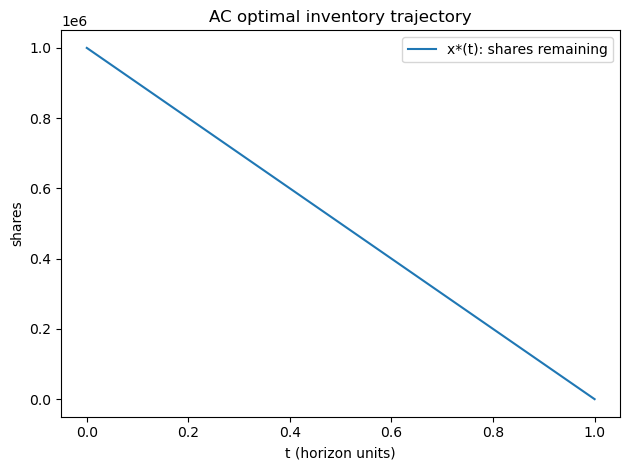

In [3]:
# --- Continuous AC schedule ---
t, x_t, v_t, params = continuous_schedule(X0=X0, T=T, sigma=sigma, eta=eta, lam=lam, gamma=gamma)
kappa = params.get('kappa')
print(f"Derived kappa = {kappa:.6g}")

# Plot x(t): shares remaining
plt.figure()
plt.plot(t, x_t, label='x*(t): shares remaining')
plt.xlabel('t (horizon units)')
plt.ylabel('shares')
plt.title('AC optimal inventory trajectory')
plt.legend()
plt.tight_layout()
plt.show()

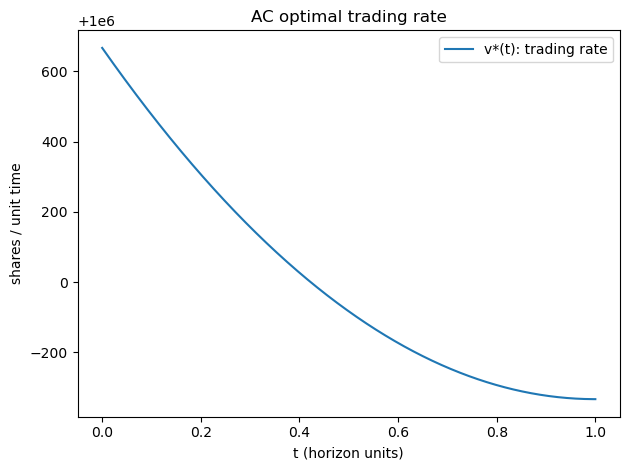

In [4]:
# Plot v(t): trading rate (shares per unit time)
plt.figure()
plt.plot(t, v_t, label='v*(t): trading rate')
plt.xlabel('t (horizon units)')
plt.ylabel('shares / unit time')
plt.title('AC optimal trading rate')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# --- Cost metrics for this schedule ---
cb, _ = continuous_cost(X0=X0, T=T, sigma=sigma, eta=eta, lam=lam, gamma=gamma, return_schedule=False)

metrics = pd.DataFrame([{
    'lambda': lam,
    'kappa': kappa,
    'E_cost': cb.E_cost,
    'Var_cost': cb.Var_cost,
    'Objective (E + lambda*Var)': cb.objective
}])
metrics

,lambda,kappa,E_cost,Var_cost,Objective (E + lambda*Var)
0,0.000005,0.044721,1.050000e+06,1.332979e+08,1.050667e+06


In [6]:
# --- Efficient frontier across lambda ---
lams = np.logspace(-8, -4, 25)
front = efficient_frontier(X0=X0, T=T, sigma=sigma, eta=eta, gamma=gamma, lambdas=lams, grid='continuous', N=721)
df_front = pd.DataFrame(front)
df_front.head()

,lambda,E_cost,Var_cost,objective,kappa
0,1.000000e-08,1.050000e+06,1.333334e+08,1.050001e+06,0.002000
1,1.467799e-08,1.050000e+06,1.333334e+08,1.050002e+06,0.002423
2,2.154435e-08,1.050000e+06,1.333333e+08,1.050003e+06,0.002936
3,3.162278e-08,1.050000e+06,1.333332e+08,1.050004e+06,0.003557
4,4.641589e-08,1.050000e+06,1.333331e+08,1.050006e+06,0.004309


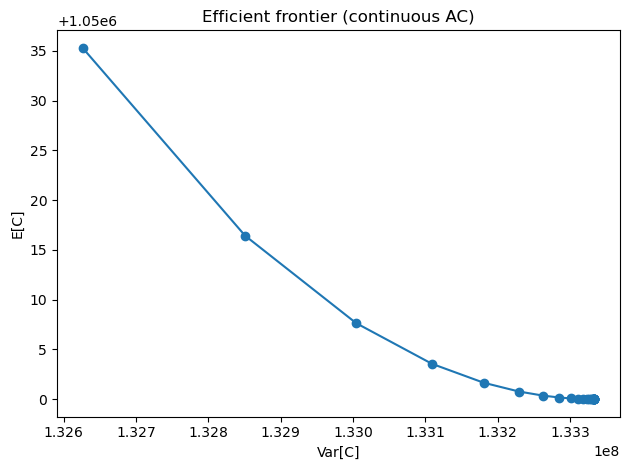

In [7]:
# Plot efficient frontier: variance (x-axis) vs expected cost (y-axis)
plt.figure()
plt.plot(df_front['Var_cost'], df_front['E_cost'], marker='o', linestyle='-')
plt.xlabel('Var[C]')
plt.ylabel('E[C]')
plt.title('Efficient frontier (continuous AC)')
plt.tight_layout()
plt.show()

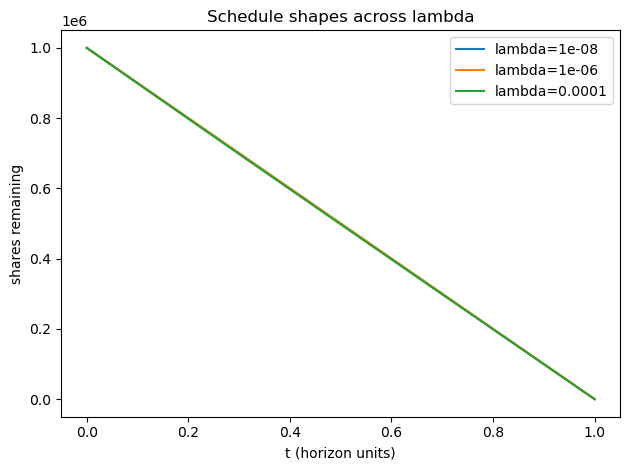

In [8]:
# --- Compare schedule shapes for different risk aversions ---
compare_lams = [1e-8, 1e-6, 1e-4]
plt.figure()
for lam_i in compare_lams:
    t_i, x_i, _, _ = continuous_schedule(X0=X0, T=T, sigma=sigma, eta=eta, lam=lam_i, gamma=gamma)
    plt.plot(t_i, x_i, label=f'lambda={lam_i:g}')
plt.xlabel('t (horizon units)')
plt.ylabel('shares remaining')
plt.title('Schedule shapes across lambda')
plt.legend()
plt.tight_layout()
plt.show()

Discrete grid: N=20, dt=0.05


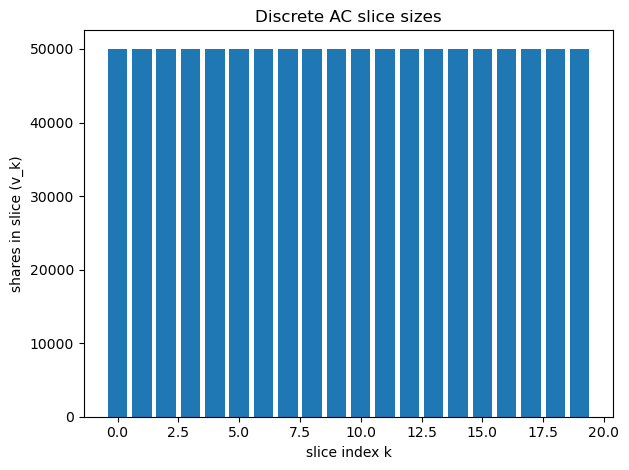

In [9]:
# --- Discrete schedule demo ---
N = 20  # slices
t_k, x_k, v_k, params_d = discrete_schedule(X0=X0, T=T, sigma=sigma, eta=eta, lam=lam, N=N, gamma=gamma)
print(f"Discrete grid: N={N}, dt={params_d.get('dt')}")

# Bar chart of slice sizes
plt.figure()
plt.bar(np.arange(N), v_k)
plt.xlabel('slice index k')
plt.ylabel('shares in slice (v_k)')
plt.title('Discrete AC slice sizes')
plt.tight_layout()
plt.show()

## Next steps

- Try changing `T` (shorter horizons reduce risk but increase impact).
- Sweep `eta` and `sigma` to see how liquidity and volatility shape the schedule.
- Switch to `grid='discrete'` in the frontier for slice-based evaluation.
- Compare against heuristic baselines: TWAP/POV (see `ac/schedules.py`).

> Tip: If imports fail when running from `examples/`, ensure the repo root is in `PYTHONPATH` or install the package in editable mode:
>
> ```bash
> pip install -e .
> ```
